<a href="https://colab.research.google.com/github/RomainReina/Progra3D_Exercices_2021/blob/main/Projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Projet réalisé par Romain REINA, Nicolas DEFOORT, Mathias MEGE.

##Introduction

Dans le cadre de notre formation à l'ISEN nous avions eu la possibilité de récupérer des données de chez Auchan afin d'effectuer des prédiction de données.
Les données que nous avons pu recueillir contiennent l'apparition d'événement (jours fériés, fêtes …) et le nombre de tickets vendu le tout séparé par période du mois.
Il nous ai demandé de faire une prédiction sur le nombre de tickets retiré dans les magasins Auchan sur le mois d'Août 2021.






## Sommaire

- [Importation des librairies](#0)
- [Partie 1:  Importation de la Data](#1)
    - [1.1  Préparation de la data](#1.1)
    - [1.2  Préparation de la data](#1.2)
- [Partie 2:  Classes Utiles](#2)
- [Partie 3:  Création du modèle ](#3)
- [Partie 4:  Vérification du modèle](#4)
- [Partie 5:  Prédiction](#5)

<a name="0"></a>
##Importation des librairies


In [ ]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torchvision.datasets import MNIST
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

<a name="1"></a>
##Partie 1:Importation de la Data

<a name="1.1"></a>
Importation de la data (le PATH est à changer suivant l'emplacement du fichier)





In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount= True)

csv = pd.read_csv("gdrive/MyDrive/IA M2/projetIAAvancé/202108_input_csv_FR_003_MAG_dataframe.csv",encoding = 'latin') 
csv

Mounted at /content/gdrive


,date,store_id,nb_tickets,f_total_qty,f_val_sales_amit_tck,dow,month,month_div,train,feature_All Saints' Day_-1,feature_All Saints' Day_-2,feature_All Saints' Day_0,feature_All Saints' Day_1,feature_Ascension Day_-1,feature_Ascension Day_-2,feature_Ascension Day_0,feature_Ascension Day_1,feature_Assumption of Mary_-1,feature_Assumption of Mary_-2,feature_Assumption of Mary_0,feature_Assumption of Mary_1,feature_Back to school_-1,feature_Back to school_-2,feature_Back to school_0,feature_Back to school_1,feature_Bastille day_-1,feature_Bastille day_-2,feature_Bastille day_0,feature_Bastille day_1,feature_Black Friday_-1,feature_Black Friday_-2,feature_Black Friday_0,feature_Black Friday_1,feature_Christmas Day_-1,feature_Christmas Day_-2,feature_Christmas Day_-3,feature_Christmas Day_-4,feature_Christmas Day_-5,feature_Christmas Day_-6,feature_Christmas Day_-7,...,feature_week_bfore_bts3_-2,feature_week_bfore_bts3_0,feature_week_bfore_bts3_1,feature_week_bfore_bts4_-1,feature_week_bfore_bts4_-2,feature_week_bfore_bts4_0,feature_week_bfore_bts4_1,feature_week_bfore_bts5_-1,feature_week_bfore_bts5_-2,feature_week_bfore_bts5_0,feature_week_bfore_bts5_1,feature_week_bfore_christmas0_-1,feature_week_bfore_christmas0_-2,feature_week_bfore_christmas0_0,feature_week_bfore_christmas0_1,feature_week_bfore_christmas1_-1,feature_week_bfore_christmas1_-2,feature_week_bfore_christmas1_0,feature_week_bfore_christmas1_1,feature_week_bfore_christmas2_-1,feature_week_bfore_christmas2_-2,feature_week_bfore_christmas2_0,feature_week_bfore_christmas2_1,feature_week_bfore_christmas3_-1,feature_week_bfore_christmas3_-2,feature_week_bfore_christmas3_0,feature_week_bfore_christmas3_1,feature_week_bfore_christmas4_-1,feature_week_bfore_christmas4_-2,feature_week_bfore_christmas4_0,feature_week_bfore_christmas4_1,feature_week_bfore_christmas5_-1,feature_week_bfore_christmas5_-2,feature_week_bfore_christmas5_0,feature_week_bfore_christmas5_1,feature_week_bfore_christmas6_-1,feature_week_bfore_christmas6_-2,feature_week_bfore_christmas6_0,feature_week_bfore_christmas6_1,dow_feature_Summer holidays_0
0,2015-05-30,FR_003_MAG,17927,319485,1106226.68,6,5,4,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60
1,2015-09-09,FR_003_MAG,11402,221630,632380.11,3,9,2,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30
2,2015-12-31,FR_003_MAG,15773,247412,976888.53,4,12,4,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40
3,2016-03-01,FR_003_MAG,8420,158870,452738.04,2,3,1,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20
4,2016-12-26,FR_003_MAG,15158,206576,801727.58,1,12,4,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2178,2017-07-13,FR_003_MAG,10151,167956,525815.69,4,7,2,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41
2179,2018-11-26,FR_003_MAG,10491,140271,567687.03,1,11,4,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10
2180,2019-02-05,FR_003_MAG,8320,133508,419414.04,2,2,1,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

<a name="1.2"></a>
Préparation de la data

In [ ]:
csv_reshaped= csv[csv.train != False] #on supprime toutes les donnés non ####

csv_reshaped = csv_reshaped[['nb_tickets','dow','month','month_div']]

# data pour construire le modèle
csv_datatrain = csv_reshaped[:700]

data_X = [csv_datatrain['dow'],csv_datatrain['month'],csv_datatrain['month_div']]
data_y = csv_datatrain['nb_tickets']
data_X = torch.FloatTensor(data_X)
data_y = torch.FloatTensor(data_y)
data_X = data_X.T



# data pour entrainer le modèle
csv_datatest = csv_reshaped[701:1401]
csv_datatest.index = np.arange(0, len(csv_datatest) )# on modifie l'index

datatest_X = [csv_datatest['dow'],csv_datatest['month'],csv_datatest['month_div']]
datatest_y = csv_datatest['nb_tickets']
datatest_X = torch.FloatTensor(datatest_X)
datatest_y = torch.FloatTensor(datatest_y)
datatest_X = datatest_X.T



# data de validation du modèle
csv_dataAPredire = csv_reshaped[1400:2100]
csv_dataAPredire.index = np.arange(0, len(csv_dataAPredire)) # on modifie l'index

dataAPredire_X = [csv_dataAPredire['dow'],csv_dataAPredire['month'],csv_dataAPredire['month_div']]
dataAPredire_y = csv_dataAPredire['nb_tickets']
dataAPredire_X = torch.FloatTensor(dataAPredire_X)
dataAPredire_y = torch.FloatTensor(dataAPredire_y)
dataAPredire_X = dataAPredire_X.T


print('Shape data_X:', data_X.shape)
print('Shape data_y:', data_y.shape)
print('Shape datatest_X:', datatest_X.shape)
print('Shape datatest_y:', datatest_y.shape)
print('Shape dataAPredire_X:', dataAPredire_X.shape)
print('Shape dataAPredire_y:', dataAPredire_y.shape)


Shape data_X: torch.Size([700, 3])
Shape data_y: torch.Size([700])
Shape datatest_X: torch.Size([700, 3])
Shape datatest_y: torch.Size([700])
Shape dataAPredire_X: torch.Size([700, 3])
Shape dataAPredire_y: torch.Size([700])


<a name="2"></a>
## Partie 2: Classes Utiles

Classe permettant d'avoir toute nos données rangé au même endroit.

In [ ]:
class Dataset():
    def __init__(self, x, y): self.x, self.y = x, y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i] 

Classe permettant de créer des jeu de données pour l'entrainement afin de pas envoyer toutes les données en même temps et surcharger le PC (jeu de données crées en fonction de batchsize).

In [ ]:
class DataLoader():
    def __init__(self, data, bs):
        self.data, self.bs = data, bs

    def __iter__(self):
        for i in range(0, len(self.data), self.bs):
            yield self.data[i:i+self.bs]

La classe Optimizer permet à chaque EPOCH de faire la descente de gradient avec la fonction step et de les remettre à zéro avec la fonction zero_grad.


In [ ]:
class Optimizer():
    # is used to get rid of code inside the training loop
    def __init__(self, parameters, lr=0.4):
        self.parameters, self.lr = list(parameters), lr

    def step(self):
        with torch.no_grad():
            for p in self.parameters:
                p -= p.grad * self.lr

    def zero_grad(self):
        for p in self.parameters:
            p.grad.zero_()

<a name="3"></a>
## Partie 3: Création du modèle

Maintenant que nos données sont prêtes, on va préparer notre modèle d'entrainement.
On définie dans un premier temps le nombre d'EPOCH, le learning rate, le batchsize et la loss que l'on va utiliser.
Nous avons décidé d'utiliser une loss de type MAE(Mean Average Error) puisque le résultat souhaité est un prédiction de nombre de tickets vendues avec un nombre infini de possibilité de résultat.

La MAE permet de mesurer la précision de notre prédiction et ainsi d'obtenir l'ecart moyen entre la valeur réelle et la prédiction effectuées.

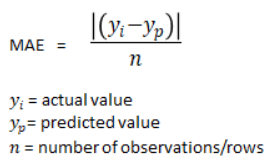 

On utilise pour le moment un modèle séquentiel pour notre entrainement qui nous permet de créer un ensemble de couches simples où chaque couche possède un tensor d'entrée et un tensor de sortie.

In [ ]:
EPOCHS = 500
lr = 0.0001
bs = 10
mae_loss = nn.L1Loss()  # MAE

# here we will later download and assign pre-trained models
model= nn.Sequential(
    nn.Linear(3, 10),
    nn.ReLU(),
    nn.Linear(10, 50),
    nn.ReLU(),
    nn.Linear(50, 10),
    nn.ReLU(),
    nn.Linear(10, 1)
)

# Your nn.Sequential has a .parameters() attribute !
# so the Optimizer find alone all the tensors that require gradients ! 
opt = Optimizer(model.parameters(), lr=lr)

my_data = Dataset(data_X, data_y)
train_dataloader = DataLoader(my_data, bs)

Cette fois place à l'entrainement, on récupère chaque ligne du dataloader et on rentre les poids dans notre modèle. On calcule ensuite la MAE avant de faire la backpropagation permettant de gagner en précision à chaque EPOCH. 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:97: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch 1/500 -- Loss: 11458.3701
Epoch 11/500 -- Loss: 11458.1699
Epoch 21/500 -- Loss: 11457.7314
Epoch 31/500 -- Loss: 11456.2666
Epoch 41/500 -- Loss: 11444.1074
Epoch 51/500 -- Loss: 3462.0029
Epoch 61/500 -- Loss: 3239.2354
Epoch 71/500 -- Loss: 3067.3884
Epoch 81/500 -- Loss: 2782.5359
Epoch 91/500 -- Loss: 2746.3540
Epoch 101/500 -- Loss: 2742.9680
Epoch 111/500 -- Loss: 2737.5671
Epoch 121/500 -- Loss: 2740.2175
Epoch 131/500 -- Loss: 2740.5425
Epoch 141/500 -- Loss: 2741.4207
Epoch 151/500 -- Loss: 2740.2705
Epoch 161/500 -- Loss: 2739.9441
Epoch 171/500 -- Loss: 2743.2878
Epoch 181/500 -- Loss: 2738.1443
Epoch 191/500 -- Loss: 2740.3953
Epoch 201/500 -- Loss: 2741.2046
Epoch 211/500 -- Loss: 2742.2017
Epoch 221/500 -- Loss: 2743.5242
Epoch 231/500 -- Loss: 2747.0540
Epoch 241/500 -- Loss: 2744.3938
Epoch 251/500 -- Loss: 2744.9355
Epoch 261/500 -- Loss: 2744.8853
Epoch 271/500 -- Loss: 2746.5635
Epoch 281/500 -- Loss: 2751.9639
Epoch 291/500 -- Loss: 2749.1226
Epoch 301/500 --

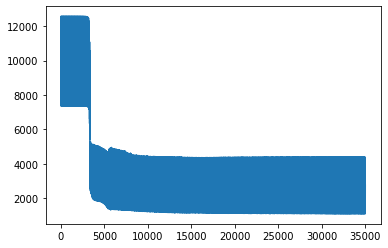

In [ ]:
losses = []
for i in range(EPOCHS):
    for xb, yb in train_dataloader:
        output = model(xb)
        loss = mae_loss(output,yb)
        losses.append(loss.item())
        # backward pass:
        loss.backward()
        
        # we've removed all the mess into opt: 
        opt.step() #replaces a.weight -= a.weight.grad * lr
        #On réinitialise les gradients à zéro.
        opt.zero_grad()
    if i % 10 == 0:
         print(f'\rEpoch {i+1}/{EPOCHS} -- Loss: {losses[-1]:0.4f}')

plt.plot(losses)

<a name="4"></a>
## Partie 4: Vérification du modèle


In [20]:
def accurency(Y_actual,Y_Predicted):
    #print("Y_actual",Y_actual)
    #print("Y_Predicted", Y_Predicted)
    accurency = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))
    return print("accurency = ", 1- accurency)

In [21]:
y_Predicted = mae_loss(model(datatest_X),data_y)
print(y_Predicted)

accurency(data_y.detach().numpy(),y_Predicted.detach().numpy())

tensor(2458.8271, grad_fn=<L1LossBackward>)
accurency =  0.27865689992904663


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:97: UserWarning: Using a target size (torch.Size([700])) that is different to the input size (torch.Size([700, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


# <a name="5"></a>
#Partie 5: Prédiction



